In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image


In [3]:
base_skin_dir = os.path.join('./data')

In [4]:
# Merge images from both folders into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
# Read in the csv of metadata

tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df.tail()


,lesion_id,image_id,dx,dx_type,age,sex,localization
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back


In [6]:
# Create some new columns (path to image, human-readable name) and review them

tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
1371,HAM_0004980,ISIC_0027693,mel,histo,45.0,female,back,./data\HAM10000_images_part_1\ISIC_0027693.jpg,Melanoma,5
7086,HAM_0005686,ISIC_0033112,nv,histo,25.0,male,back,./data\HAM10000_images_part_2\ISIC_0033112.jpg,Melanocytic nevi,4
5638,HAM_0001836,ISIC_0030500,nv,follow_up,40.0,female,abdomen,./data\HAM10000_images_part_2\ISIC_0030500.jpg,Melanocytic nevi,4
9325,HAM_0007484,ISIC_0031750,nv,consensus,15.0,female,lower extremity,./data\HAM10000_images_part_2\ISIC_0031750.jpg,Melanocytic nevi,4
2262,HAM_0002131,ISIC_0030995,mel,histo,55.0,male,upper extremity,./data\HAM10000_images_part_2\ISIC_0030995.jpg,Melanoma,5


In [7]:
# Get general statistics for the dataset

tile_df.describe(exclude=[np.number])


,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0000835,ISIC_0032955,nv,histo,male,back,./data\HAM10000_images_part_1\ISIC_0027334.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


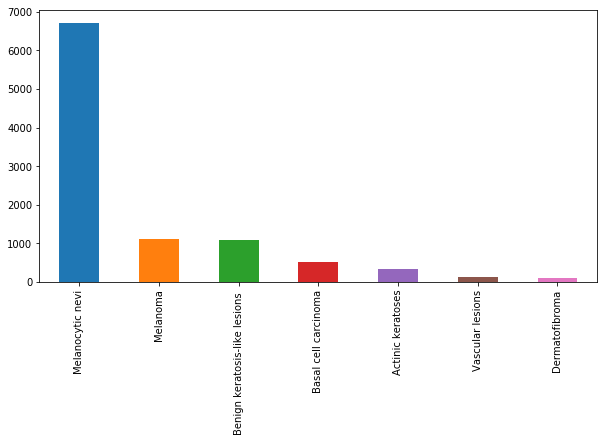

In [8]:
# Let's see the distribution of different cell types

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)


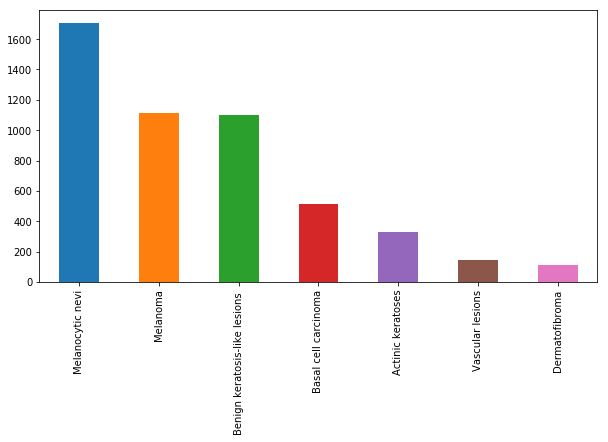

In [9]:
# Too many melanocytic nevi - let's balance it a bit!

tile_df = tile_df.drop(tile_df[tile_df.cell_type_idx == 4].iloc[:5000].index)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)



In [10]:
input_dims = (50, 50)
input_shape = input_dims + (3,)

# Load in all of the images into memory - this will take a while.  
# We also do a resize step because the original dimensions of 450 * 600 * 3 was too much for TensorFlow

tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))

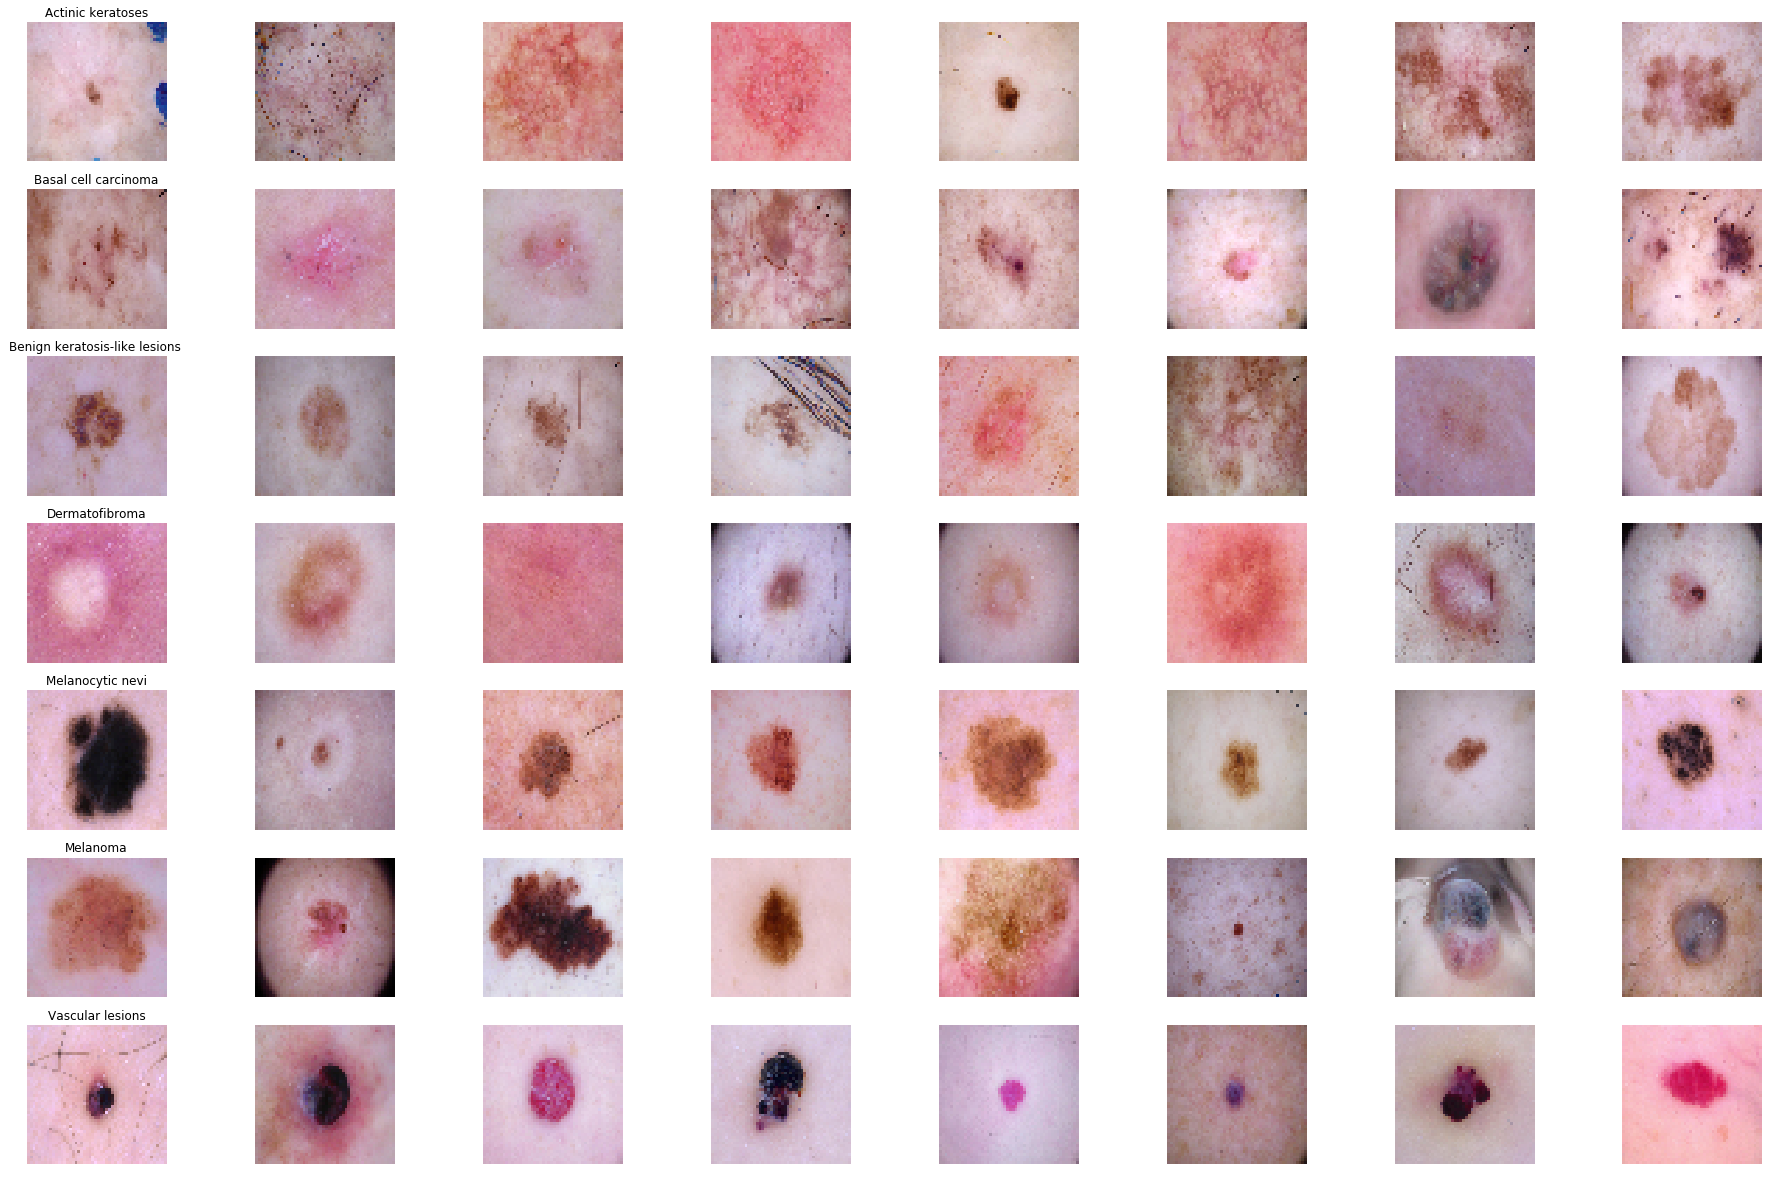

In [11]:
n_samples = 8
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [12]:
# See the image size distribution - should just return one row (all images are uniform)
tile_df['image'].map(lambda x: x.shape).value_counts()

(50, 50, 3)    5015
Name: image, dtype: int64

In [14]:
# Export to csv 
tile_df.to_csv('processed_data.csv')